<table style="width:100%">
  <tr>
    <th> <img src="logo_EPM_UNIOVI_CabeceroWEB.gif" alt="Uniovi & EP Mieres logos" title="Uniovi & EP Mieres logos" /></th>
    <th><font color=brown>Procesamiento de imágenes de Sensores Aerotransportados y Satélite</font>
         </font></th> 
    <th><font color=green>Universidad de Oviedo.                       Ingeniería en Geomática</font>        sgcortes@uniovi.es</th>
  </tr>
</table>

Veamos las funciones de OpenCV que se encargan de las transformaciones geométricas de las imágenes. Los links de la librería y la documentación correspondiente son: https://opencv.org/ 
https://docs.opencv.org/3.4.3/index.html

Las transformaciones vistas en la sección anterior (escalado, traslación, rotación) generalmente se componen en una sola transformación global que se aplica conjuntamente. En el caso de transformación proyectiva (que es no-afín y por lo tanto no respeta el paralelismo), se emplea para corregir la distorsión perspectiva.

### 2.2.1 Transformación Proyectiva

[[ 7.76546388e-01  3.06703195e-01 -2.53095392e+02]
 [-4.52324268e-01  8.59416109e-01  1.31852524e+02]
 [-2.46841082e-04  9.96627311e-05  1.00000000e+00]]


True

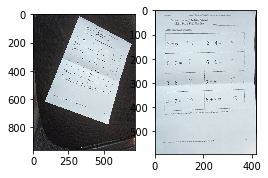

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('scan.jpg')
plt.figure(1,figsize=(4,18))
plt.subplot(121)
plt.imshow(image)

# Cordenadas de 4 esquinas de la imagen original
points_A = np.float32([[320,15], [700,215], [85,610], [530,780]])

# Coordenadas de las 4 esquinas deseadas
# El papel es un DIN A4 que tiene un ratio de aspecto 1 : 1.41
points_B = np.float32([[0,0], [420,0], [0,594], [420,594]])
 
# Calculamos la matriz de transformacion proyectiva, M    
M = cv2.getPerspectiveTransform(points_A, points_B)
print(M)
# Aplicamos la transformacion
warped = cv2.warpPerspective(image, M, (420,594))
plt.subplot(122)
plt.imshow(warped)
cv2.imwrite('warped.jpg', warped)

### 2.2.2 Transformación afín
**cv2.getAffineTransform(points_A, points_B)**.La función calcula una transformación afín . **Necesita y admite para el cálculo solamente 3 puntos**. Apliquemos la transformación a la imagen rectificada anterior (warped). Es importante que los ejes x e y sean de escalas iguales en la representación.

[[ 9.04761905e-01 -2.86195286e-01  3.20000000e+02]
 [ 4.76190476e-01  9.51178451e-01  1.50000000e+01]]


Text(0.5,1,'Afín')

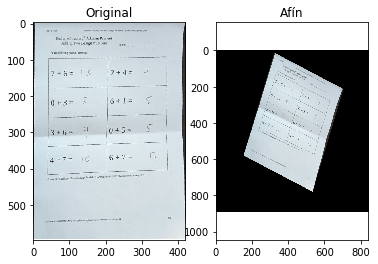

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('warped.jpg')
rows,cols,ch = image.shape

fig, ax = plt.subplots(1,2)

ax[0].imshow(image)
ax[0].axis('equal')
ax[0].set_title('Original')

# Coordenadas de 3 esquinas de la imagen original
points_A = np.float32([[0,0], [420,0], [420,594]])
# las coordenadas son [cols, fils]=[x,y]

# Coordenadas de las 3 esquinas deseadas
points_B = np.float32([[320,15], [700,215], [530,780]])
 
# La matriz Afin Transformation matrix, A    
A = cv2.getAffineTransform(points_A, points_B)
print(A)
warped = cv2.warpAffine(image, A, (2*cols, int(1.5*rows)))

ax[1].imshow(warped)
ax[1].axis('equal')
ax[1].set_title('Afín')

La figura del papel está algo deformada porque las coordenadas de los 3 puntos que hemos empleado provienen de la imagen que contenía una transformación proyectiva. Tratemos de construir nosotros una matriz de transformación afín.

In [51]:
#       | 1 0 Tx |
#  T  = | 0 1 Ty |

# TRaslación
Tx=100
Ty=50
T = np.float32([[1, 0, Tx], [0, 1,Ty],[0,0,1]])
print('Matriz de traslación:\n ',T)
# Rotación
R = cv2.getRotationMatrix2D((rows/2, cols/2), 45, .5)
    #R = np.pad(R,((0,1),(0,0)), mode = 'constant')
    #R[2,2]=1
    #print(R)
    #print(R.shape)
R = np.append(R,[[0., 0., 1.]], axis=0)
print('Matriz de rotación:\n ', R)

# Matriz de factor de escala
d=np.array([1.3,1.,1]) 
S = np.diag(d,0) # diag funciona con vectores columna
# para funcionar con vectores filas tendríamos que poner :
#S = np.diag(d[0:])
print('Matriz de factor de escala:\n', S)

# Multiplicamos las matrices para conseguir la matriz afín completa (@ producto de matrices)
Taf = S @ R @ T
print(Taf)

Matriz de traslación:
  [[  1.   0. 100.]
 [  0.   1.  50.]
 [  0.   0.   1.]]
Matriz de rotación:
  [[  0.35355339   0.35355339 117.74843097]
 [ -0.35355339   0.35355339 240.75914498]
 [  0.           0.           1.        ]]
Matriz de factor de escala:
 [[1.3 0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]]
[[  0.45961941   0.45961941 222.01587143]
 [ -0.35355339   0.35355339 223.08147545]
 [  0.           0.           1.        ]]


La matriz que recibe cv2.warpAffine debe ser una matriz sin la tercera fila que en el caso de las trasnformaciones afines es siempre [0,0,1]. 

[[  0.45961941   0.45961941 222.01587143]
 [ -0.35355339   0.35355339 223.08147545]]


Text(0.5,1,'Afín')

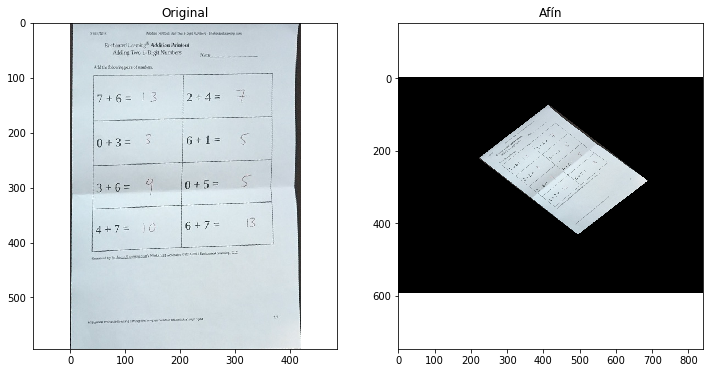

In [52]:
Taf = Taf[0:2:]
print(Taf)
warped2 = cv2.warpAffine(image, Taf, (int(2*cols), int(1*rows)))
plt.figure(2,figsize=(12,6)) # anchura altura de la figura
plt.subplot(121)
plt.imshow(image)
plt.axis('equal')
plt.title('Original')
plt.subplot(122)
plt.imshow(warped2)
plt.axis('equal')
plt.title('Afín')

Podemos ver como se conserva el paralelismo entre lados opuestos del borde de la hoja (al contrario que en la deformación proyectiva), mientras que la deformación de la página (los ángulos de las esquinas no son de 90º) se debe a que hemos empleado un factor de escala mayor en la dirección de las filas que el de las columnas.  S =diag([fcol,ffil,1]).